# Transformer model for Russian Language Translation

### Introduction
This walkthrough translates Russian to English. The purpose is to show a detailed low-level implementation of the original Transformer architecture as described in Vaswani, et al. 2017 from Google Brain (https://arxiv.org/abs/1706.03762). It also shows an implementation of Subword Tokenization using the BERT tokenizer. 

This implementation is modified from the following Google Tensorflow Tutorials: 
* https://www.tensorflow.org/tutorials/tensorflow_text/subwords_tokenizer
* https://www.tensorflow.org/tutorials/text/transformer

which are:
* Copyright 2019 The TensorFlow Authors.
* Licensed under the Apache License, Version 2.0 (the "License");

In addition, the following modifications have been made by Hamilton Hitchigs:
* Changed the source language from Portugese to Russian
* Added accuracy tests to the end such as Bleu
* Changed code so it will save the converter and transformer model to Google drive and reuse if they already exist.




The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It makes no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Setup

In [5]:
from google.colab import drive # Load the Drive helper and mount

drive.mount('/content/drive') # This will prompt for authorization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
BASE_MODEL_PATH = 'drive/MyDrive/models/transformer_ru_en_v2'
BASE_DATA_PATH = 'drive/MyDrive/data/transformer_ru_en_v2'
CONVERTER_MODEL_NAME = 'ted_hrlr_translate_ru_en_converter'
build_tokenizer = False

In [7]:
!ls drive/MyDrive/models/transformer_ru_en_v2/

ted_hrlr_translate_ru_en_converter


In [8]:
#Cleanup for a fresh start
#!rm -rf drive/MyDrive/data/downloads/*
#!rm -Rf $BASE_MODEL_PATH/*
#!rm -Rf $BASE_DATA_PATH/*

In [9]:
import os.path
from os import path

In [10]:
if not path.exists(BASE_MODEL_PATH):
  os.mkdir(BASE_MODEL_PATH)
  print(f'Created model directory {BASE_MODEL_PATH}')

if not path.exists(BASE_DATA_PATH):
  os.mkdir(BASE_DATA_PATH)
  print(f'Created model directory {BASE_DATA_PATH}')

In [11]:
print(BASE_MODEL_PATH)
!ls $BASE_MODEL_PATH
print(BASE_DATA_PATH)
!ls $BASE_DATA_PATH

drive/MyDrive/models/transformer_ru_en_v2
ted_hrlr_translate_ru_en_converter
drive/MyDrive/data/transformer_ru_en_v2
downloads  en_vocab.txt  ru_vocab.txt  ted_hrlr_translate


In [12]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

In [13]:
pip install rouge

In [14]:
import nltk
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [15]:
if not path.exists(BASE_MODEL_PATH + '/' + CONVERTER_MODEL_NAME):
  build_tokenizer = True
  print(f"Building tokenizer since not found at {BASE_MODEL_PATH}/{CONVERTER_MODEL_NAME}")

  # `BertTokenizer.detokenize` is not in `tf-text` stable yet (currently 2.4.3).
  os.system("pip install -q tensorflow_text_nightly > /tmp/out.txt")

  # tf-text-nightly resquires tf-nightly
  os.system("pip install -q tf-nightly >> /tmp/out.txt")

  # Generate the vocabulary
  os.system("cat /tmp/out.txt")
else:
  build_tokenizer = False
  print(f"Tokenizer already exists at {BASE_MODEL_PATH}/{CONVERTER_MODEL_NAME}")
  os.system("pip install -q tensorflow_text > /tmp/out.txt")
  os.system("cat /tmp/out.txt")

Tokenizer already exists at drive/MyDrive/models/transformer_ru_en_v2/ted_hrlr_translate_ru_en_converter


In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_text as text

if build_tokenizer:
  # Generate the vocabulary
  from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [17]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Download the Dataset

Use [TensorFlow datasets](https://www.tensorflow.org/datasets) to load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [18]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True, data_dir=BASE_DATA_PATH)
train_examples, val_examples, test_examples = examples['train'], examples['validation'], examples['test']

The `tf.data.Dataset` object returned by TensorFlow datasets yields pairs of text examples:

In [19]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


## Text tokenization & detokenization

For more detail on how to build the tokenizer and detokenizer see: https://www.tensorflow.org/tutorials/tensorflow_text/subwords_tokenizer

You can't train a model directly on text. The text needs to be converted some numeric representation first. Typically you convert the text to sequences of token IDs, which are as indexes into an embedding.

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/tutorials/tensorflow_text/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model). 

Download and unzip and import the `saved_model`:

In [20]:
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  global START, END
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

def write_vocab_file(filepath, vocab):
  global base_path
  with open(BASE_DATA_PATH + '/' + filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

def write_vocab_files():
  global reserved_tokens, train_example
  bert_tokenizer_params=dict(lower_case=True)

  bert_vocab_args = dict(
      # The target vocabulary size
      vocab_size = 30000,
      # Reserved tokens that must be included in the vocabulary
      reserved_tokens=reserved_tokens,
      # Arguments for `text.BertTokenizer`
      bert_tokenizer_params=bert_tokenizer_params,
      # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
      learn_params={},
  )

  train_en = train_examples.map(lambda ru, en: en)
  train_ru = train_examples.map(lambda ru, en: ru)

  %%time
  ru_vocab = bert_vocab.bert_vocab_from_dataset(
      train_ru.batch(1000).prefetch(2),
      **bert_vocab_args
  )

  print(f'ru_vocab with length={len(ru_vocab)}')
  write_vocab_file('ru_vocab.txt', ru_vocab)

  %%time
  en_vocab = bert_vocab.bert_vocab_from_dataset(
      train_en.batch(1000).prefetch(2),
      **bert_vocab_args
  )

  print(f'en_vocab with length={len(en_vocab)}')
  write_vocab_file('en_vocab.txt', en_vocab)

def cleanup_text(reserved_tokens, token_txt):
  # Generate clean text output, so drop reserved tokens like [START], [END] and [PAD].
  # apply a string join along the words axis of the result.

  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

def build_bert_tokenizer():
  ru_tokenizer = text.BertTokenizer(BASE_DATA_PATH + '/' + 'ru_vocab.txt', **bert_tokenizer_params)
  en_tokenizer = text.BertTokenizer(BASE_DATA_PATH + '/' + 'en_vocab.txt', **bert_tokenizer_params)

  # Run it through the BertTokenizer.tokenize method. Initially, this returns a 
  # tf.RaggedTensor with axes (batch, word, word-piece):*italicized text*

  # Custom detokenization
  # Tokenize the examples -> (batch, word, word-piece)
  # Merge the word and word-piece axes -> (batch, tokens)
  token_batch = en_tokenizer.tokenize(en_examples).merge_dims(-2,-1)
  words = en_tokenizer.detokenize(token_batch)

### Export Custom BERT Tokenizer
The following code block builds a CustomTokenizer class to contain the text.BertTokenizer instances, the custom logic, and the @tf.function wrappers required for export.

In [21]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

Build a CustomTokenizer for each language:

In [22]:
def build_custom_tokenizers():
  tokenizers = tf.Module()
  tokenizers.ru = CustomTokenizer(reserved_tokens, BASE_DATA_PATH + '/' + 'ru_vocab.txt')
  tokenizers.en = CustomTokenizer(reserved_tokens, BASE_DATA_PATH + '/' + 'en_vocab.txt')

  # Export the tokenizers as a saved_model:
  tf.saved_model.save(tokenizers, BASE_MODEL_PATH + '/' + CONVERTER_MODEL_NAME)

  # Generate the vocabulary
  os.system("zip -r $BASE_MODEL_PATH/{BASE_MODEL_PATH}.zip $BASE_MODEL_PATH/{CONVERTER_MODEL_NAME} > /tmp/out.txt")
  os.system("cat /tmp/out.txt")

  return tokenizers

In [23]:
if build_tokenizer:
  global BASE_MODEL_PATH, CONVERTER_MODEL_NAME
  print("writing vocab files")
  write_vocab_files()
  print("building custom BERT tokenizer")
  tokenizers = build_custom_tokenizers()
else:
  tokenizers = reloaded_tokenizers = tf.saved_model.load(BASE_MODEL_PATH + '/' + CONVERTER_MODEL_NAME)
  reloaded_tokenizers.en.get_vocab_size().numpy()
  print(f"Loaded custom BERT tokenizer from {BASE_MODEL_PATH}/{CONVERTER_MODEL_NAME}")

Loaded custom BERT tokenizer from drive/MyDrive/models/transformer_ru_en_v2/ted_hrlr_translate_ru_en_converter


In [24]:
!ls -l $BASE_MODEL_PATH

total 4
drwx------ 4 root root 4096 Mar 28 02:16 ted_hrlr_translate_ru_en_converter


The `tf.saved_model` contains two text tokenizers, one for English and one for Portugese. Both have the same methods:

In [25]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [26]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [27]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 41, 28, 1040, 14, 84, 238, 93, 197, 376, 214, 84, 5656, 87, 84, 2307, 16, 3]
[2, 84, 10661, 85, 84, 672, 15, 103, 1405, 8003, 93, 185, 424, 15, 888, 85, 2360, 110, 84, 1005, 5132, 16, 3]
[2, 10, 388, 11, 166, 655, 11892, 136, 28, 90, 9, 57, 307, 53, 9, 2330, 89, 84, 774, 16, 3]


The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [28]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .
( video ) didi pickles : it ' s four o ' clock in the morning .


The lower level `lookup` method converts from token-IDs to token text:

In [29]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'c', b':', b'success', b',', b'the', b'change', b'is', b'only', b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun', b'.', b'[END]'], [b'[START]', b'the', b'documentation', b'and', b'the', b'hands', b'-', b'on', b'teaching', b'methodology', b'is', b'also', b'open', b'-', b'source', b'and', b'released', b'as', b'the', b'creative', b'commons', b'.', b'[END]'], [b'[START]', b'(', b'video', b')', b'did', b'##i', b'pickle', b'##s', b':', b'it', b"'", b's', b'four', b'o', b"'", b'clock', b'in', b'the', b'morning', b'.', b'[END]']]>

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serindipity" into "s ##ere ##nd ##ip ##ity"

In [30]:
if build_tokenizer:
  print("Recommend factory reset notebook and rerunning since training runs much slower with nightly build code")

## Setup input pipeline

To build an input pipeline suitable for training you'll apply some transformations to the dataset.

This function will be used to encode the batches of raw text:

In [31]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    # Convert from ragged to dense, padding with zeros.
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return ru, en

Here's a simple input pipeline that processes, shuffles and batches the data:

In [32]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [33]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE, drop_remainder=True)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [34]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [35]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


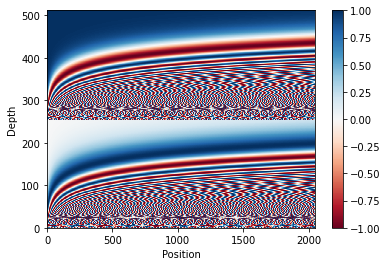

In [36]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [37]:
pos_encoding.shape

TensorShape([512, 2048])

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [38]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [39]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [40]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [41]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention



<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initilization making it dificult to learn. 

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [42]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [43]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [44]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [45]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [46]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [47]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [48]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [49]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [50]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [51]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [52]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [53]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [55]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [56]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    print(f'Port Encoder::init input_vocab_size={input_vocab_size}, d_model={d_model}')
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [57]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

Port Encoder::init input_vocab_size=8500, d_model=512
(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [58]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [59]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [60]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [61]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=29900, target_vocab_size=16000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

Port Encoder::init input_vocab_size=29900, d_model=512


TensorShape([64, 36, 16000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [62]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [63]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [64]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

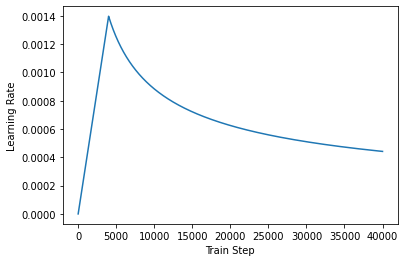

In [65]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [66]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [67]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [68]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [69]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.ru.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(), 
    pe_input=1000, 
    pe_target=1000,
    rate=dropout_rate)

Port Encoder::init input_vocab_size=29970, d_model=128


In [70]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [71]:
checkpoint_path = BASE_MODEL_PATH

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

model_already_built = False

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')
  model_already_built = True

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [72]:
EPOCHS = 20

In [73]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [74]:
def train_model(epochs, train_batches, train_loss, train_accuracy, ckpt_manager):
  for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inp -> portuguese, tar -> english
    batch_start = time.time()
    for (batch, (inp, tar)) in enumerate(train_batches):
        
      train_step(inp, tar)
      
      if batch % 50 == 0:
        print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} with time taken {time.time() - batch_start:.2f} secs')
        batch_start = time.time()

    #if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
      
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [75]:
if not model_already_built:
  train_model(EPOCHS, train_batches, train_loss, train_accuracy, ckpt_manager)

Epoch 1 Batch 0 Loss 9.7155 Accuracy 0.0000 with time taken 14.90 secs
Epoch 1 Batch 50 Loss 9.6599 Accuracy 0.0026 with time taken 4.64 secs
Epoch 1 Batch 100 Loss 9.5676 Accuracy 0.0235 with time taken 4.43 secs
Epoch 1 Batch 150 Loss 9.4477 Accuracy 0.0324 with time taken 4.47 secs
Epoch 1 Batch 200 Loss 9.2898 Accuracy 0.0367 with time taken 4.42 secs
Epoch 1 Batch 250 Loss 9.0959 Accuracy 0.0396 with time taken 4.49 secs
Epoch 1 Batch 300 Loss 8.8744 Accuracy 0.0434 with time taken 4.51 secs
Epoch 1 Batch 350 Loss 8.6338 Accuracy 0.0495 with time taken 4.55 secs
Epoch 1 Batch 400 Loss 8.3959 Accuracy 0.0546 with time taken 4.57 secs
Epoch 1 Batch 450 Loss 8.1757 Accuracy 0.0596 with time taken 4.54 secs
Epoch 1 Batch 500 Loss 7.9833 Accuracy 0.0661 with time taken 4.47 secs
Epoch 1 Batch 550 Loss 7.8124 Accuracy 0.0736 with time taken 4.51 secs
Epoch 1 Batch 600 Loss 7.6549 Accuracy 0.0813 with time taken 4.59 secs
Epoch 1 Batch 650 Loss 7.5104 Accuracy 0.0885 with time taken 4.46

In [76]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(BASE_MODEL_PATH + '/' + 'final_model.h5', save_weights_only=False)

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* The model makes predictions of the next word for each word in the output. Most of these are redundant. Use the predictrions from the last word.
* Concatentate the predicted word to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [77]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.ru.tokenize(sentence).to_tensor()

  encoder_input = sentence
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)
    
  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0] # shape: ()
  
  tokens = tokenizers.en.lookup(output)[0]
  
  return text, tokens, attention_weights

In [78]:
# Some quick cleanup code, not production thoroughness
def cleanup_punctuation(txt):
  txt = txt.replace('`', '')
  txt = txt.replace('\'', '')
  txt = txt.replace(',', '')
  txt = txt.replace(';', '')
  txt = txt.replace('  ', ' ')
  txt = txt.replace('  ', ' ')
  txt = txt.replace('\. ', '.')
  txt = txt.lstrip()
  txt = txt.rstrip()
  return txt

def print_translation(sentence, translated_text, reference):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Reference":15s}: {reference}')
  print(f'{"Prediction":15s}: {translated_text.numpy().decode("utf-8")}')

  translated_text = translated_text.numpy().decode("utf-8") 
  translated_text_split = translated_text.split(' ')
  reference_split = reference.split(' ')

  rouge = Rouge()
  rouge_scores = rouge.get_scores(translated_text, reference)
  print(f"Rouge-l (f): {100*rouge_scores[0]['rouge-l']['f']:.2f}")

  smoothie = SmoothingFunction().method4

  score = sentence_bleu([reference_split], translated_text_split, weights=(1.0,0,0,0), smoothing_function=smoothie)
  print(f"BLEU-1 score: {score*100:.2f}")
  score = sentence_bleu([reference_split], translated_text_split, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
  print(f"BLEU-2 score: {score*100:.2f}")
  score = sentence_bleu([reference_split], translated_text_split, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
  print(f"BLEU-3 score: {score*100:.2f}")
  score = sentence_bleu([reference_split], translated_text_split, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)
  print(f"BLEU-4 score: {score*100:.2f}")


In [79]:
input_sentence = "У нас есть проблема, которую мы должны решить."
reference = "we have a problem that we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(input_sentence)
print_translation(input_sentence, translated_text, reference)

Input:         : У нас есть проблема, которую мы должны решить.
Reference      : we have a problem that we have to solve .
Prediction     : we have a problem that we have to solve .
Rouge-l (f): 100.00
BLEU-1 score: 100.00
BLEU-2 score: 100.00
BLEU-3 score: 100.00
BLEU-4 score: 100.00


In [80]:
input_sentence = "Какой ваш любимый фильм?"
reference = "what is your favorite movie ?"

translated_text, translated_tokens, attention_weights = evaluate(input_sentence)
print_translation(input_sentence, translated_text, reference)

Input:         : Какой ваш любимый фильм?
Reference      : what is your favorite movie ?
Prediction     : what ' s your favorite movie ?
Rouge-l (f): 76.92
BLEU-1 score: 71.43
BLEU-2 score: 59.76
BLEU-3 score: 55.78
BLEU-4 score: 43.47


In [81]:
input_sentence = "Вы видели мой кошелек, который я потерял, когда был на работе?"
ground_truth = "have you seen my wallet that i lost when i was at work ?"

translated_text, translated_tokens, attention_weights = evaluate(input_sentence)
print_translation(input_sentence, translated_text, ground_truth)

Input:         : Вы видели мой кошелек, который я потерял, когда был на работе?
Reference      : have you seen my wallet that i lost when i was at work ?
Prediction     : have you seen my wallet , who i lost my life when i was working ?
Rouge-l (f): 74.07
BLEU-1 score: 68.75
BLEU-2 score: 56.64
BLEU-3 score: 48.83
BLEU-4 score: 34.46


In [82]:
input_sentence = "и мои соседние дома слышали об этой идее."
reference = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(input_sentence)
print_translation(input_sentence, translated_text, reference)

Input:         : и мои соседние дома слышали об этой идее.
Reference      : and my neighboring homes heard about this idea .
Prediction     : and my neighbors were hearing about this idea .
Rouge-l (f): 62.50
BLEU-1 score: 66.67
BLEU-2 score: 57.74
BLEU-3 score: 49.39
BLEU-4 score: 35.49


In [83]:
input_sentence = "Я пошел в магазин за продуктами."
reference = "i went to the store to buy some groceries ."

translated_text, translated_tokens, attention_weights = evaluate(input_sentence)
print_translation(input_sentence, translated_text, reference)

Input:         : Я пошел в магазин за продуктами.
Reference      : i went to the store to buy some groceries .
Prediction     : i went to the store .
Rouge-l (f): 76.92
BLEU-1 score: 51.34
BLEU-2 score: 45.92
BLEU-3 score: 44.05
BLEU-4 score: 40.83


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

## Attention plots

The `evaluate` function also returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [84]:
sentence = "это первая книга, которую я написал."
ground_truth = "this is the first book i ' ve ever done ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : это первая книга, которую я написал.
Reference      : this is the first book i ' ve ever done .
Prediction     : this is the first book i wrote .
Rouge-l (f): 70.59
BLEU-1 score: 60.14
BLEU-2 score: 54.33
BLEU-3 score: 52.85
BLEU-4 score: 48.60


In [85]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it. 
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  
  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)
  
  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [86]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape  

TensorShape([9, 10])

In [87]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.ru.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'\xd1\x8d\xd1\x82\xd0\xbe',
       b'\xd0\xbf\xd0\xb5\xd1\x80\xd0\xb2\xd0\xb0\xd1\x8f',
       b'\xd0\xba\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb0', b',',
       b'\xd0\xba\xd0\xbe\xd1\x82\xd0\xbe\xd1\x80\xd1\x83\xd1\x8e',
       b'\xd1\x8f',
       b'\xd0\xbd\xd0\xb0\xd0\xbf\xd0\xb8\xd1\x81\xd0\xb0\xd0\xbb', b'.',
       b'[END]'], dtype=object)>

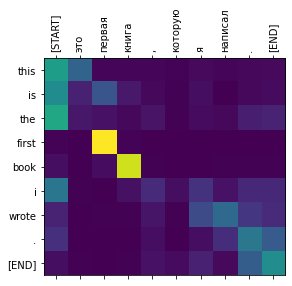

In [88]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [89]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.ru.lookup(in_tokens)[0]
  in_tokens
  
  fig = plt.figure(figsize=(16, 8))
  
  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)
    
    plot_attention_head(in_tokens, translated_tokens, head)
    
    ax.set_xlabel('Head {}'.format(h+1))
  
  plt.tight_layout()
  plt.show()

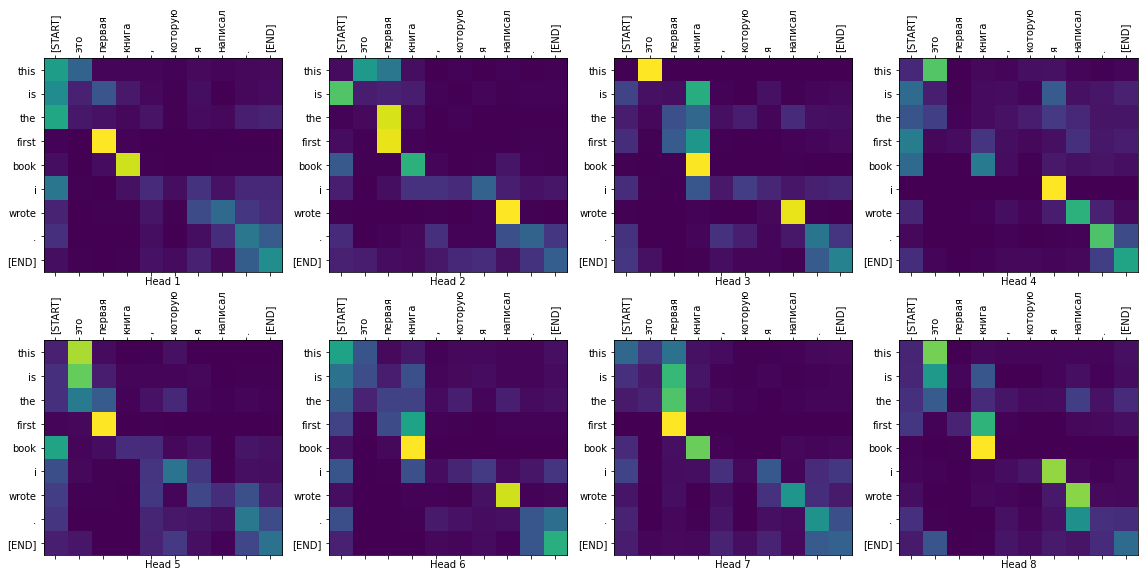

In [90]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterare them, even withoput a shared vocabulary:

In [91]:
input_sentence = "Я читал о трицератопсе в энциклопедии."
reference = "i read about triceratops in the encyclopedia ."

translated_text, translated_tokens, attention_weights = evaluate(input_sentence)
print_translation(input_sentence, translated_text, reference)

Input:         : Я читал о трицератопсе в энциклопедии.
Reference      : i read about triceratops in the encyclopedia .
Prediction     : i read about the three - carcips in the encyclopedia .
Rouge-l (f): 75.00
BLEU-1 score: 63.64
BLEU-2 score: 56.41
BLEU-3 score: 51.01
BLEU-4 score: 33.93


In [92]:
print("This will take a minute...")
references = []
candidates = []

TEST_SET_SIZE = 100
MAX_SENTENCE_CHARS = 80

i = 0
for ru_example, en_example in test_examples.take(TEST_SET_SIZE * 5):
  input_sentence = cleanup_punctuation(ru_example.numpy().decode('utf-8'))

  # Skip long sentences of greater than 100 characters
  if len(input_sentence) < MAX_SENTENCE_CHARS:

    reference = cleanup_punctuation(en_example.numpy().decode('utf-8'))
    reference_split = reference.split(' ')
    candidate, translated_tokens, attention_weights = evaluate(input_sentence)
    candidate = candidate
    candidate_split = candidate.numpy().decode('utf-8').split(' ')
    references.append([reference_split])
    candidates.append(candidate_split)

    if i < 3:
      print_translation(input_sentence, candidate, reference)
      print("")
      #print(f'Input: {input_sentence}')
      #print(f'Reference: {reference}')
      #print(f'Candidate: {translated_text}\n')

    i += 1
    if i == TEST_SET_SIZE:
      print(f"Evaluated test set with {i} sentences")
      break

This will take a minute...
Input:         : так что целое буквально больше чем сумма его частей .
Reference      : so the whole is literally more than the sum of its parts .
Prediction     : so it ' s literally more than the sum of its parts .
Rouge-l (f): 78.26
BLEU-1 score: 76.92
BLEU-2 score: 71.61
BLEU-3 score: 71.47
BLEU-4 score: 66.52

Input:         : ( смех ) ладно позвольте мне отвлечься на секудну и поблагодарить команду .
Reference      : ( laughter ) all right let me just take a moment and thank the team .
Prediction     : ( laughter ) okay , let me step back to the coast of the door and thank you for the team .
Rouge-l (f): 52.94
BLEU-1 score: 45.45
BLEU-2 score: 36.04
BLEU-3 score: 27.17
BLEU-4 score: 23.03

Input:         : мне 27 лет .
Reference      : i m 27 years old .
Prediction     : i ' m 27 years old .
Rouge-l (f): 90.91
BLEU-1 score: 85.71
BLEU-2 score: 75.59
BLEU-3 score: 72.53
BLEU-4 score: 64.35

Evaluated test set with 100 sentences


In [93]:
#references = [[['this', 'is', 'a', 'test']]]
#references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
#candidates = [['this', 'is', 'a', 'test']]
smoothie = SmoothingFunction().method4
score = corpus_bleu(references, candidates, smoothing_function=smoothie)
print(f'Bleu Corpus score: {score:.2}')

Bleu Corpus score: 0.19
